In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import librosa
from sklearn.decomposition import PCA
import torch
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from scipy.spatial import distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cosine

### Function to create MFCC coefficients

In [2]:
def create_MFCC_coefficients(file_name):
    sr_value = 44100
    n_mfcc_count = 20
    try:
        y, sr = librosa.load(file_name, sr=sr_value)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_count)
        coeff_df = pd.DataFrame(mfccs)
        return coeff_df.T
    except:
        return None

## GTZAN data for pretraining 

In [3]:
L = 2584
gtzan_Data = []
gtzan_Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    file_names = os.listdir(os.path.join(folder_path, folder))
    for file in file_names:
        file_path = os.path.join(folder_path, folder, file)
        mfcc_data = create_MFCC_coefficients(file_path) 
        if mfcc_data is not None:
            delta_mfcc = librosa.feature.delta(mfcc_data)
            delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
            interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
            for i in range(mfcc_data.shape[1]):
                interleaved_mfcc[i * 3] = mfcc_data[i]
                interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
                interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
            mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T

            if len(mfcc_data_scaled) < L:
                padding = L - len(mfcc_data_scaled)
                mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
            elif len(mfcc_data_scaled) > L:
                mfcc_data_scaled = mfcc_data_scaled[:L, :]

            gtzan_Data.append(np.array(mfcc_data_scaled))
            gtzan_Label.append(folder)

/tmp/ipykernel_30/1861942266.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=sr_value)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<Axes: >

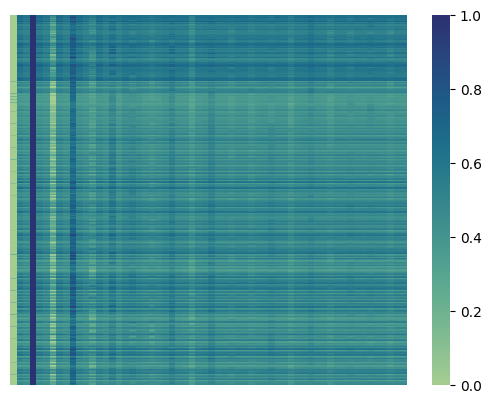

In [4]:
sns.heatmap(gtzan_Data[0],cmap='crest', xticklabels=False, yticklabels=False)

<Axes: >

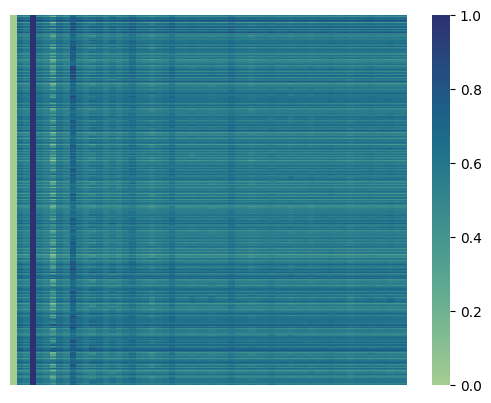

In [5]:
sns.heatmap(gtzan_Data[2],cmap='crest', xticklabels=False, yticklabels=False)

In [6]:
label_encoder = LabelEncoder()
gtzan_Label = label_encoder.fit_transform(gtzan_Label)

In [7]:
def create_sandwiched_vgg19(input_shape=(2584, 60, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), padding='same')(inputs)
    x = layers.LeakyReLU(negative_slope=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Conv2D(3, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.UpSampling2D(size=(8, 8))(x)
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(320, 120, 3))
    base_model.trainable = False
    x = base_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = create_sandwiched_vgg19()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,053,773 (91.76 MB)

 Trainable params: 4,029,389 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
Data = np.array(gtzan_Data)
labels = np.array(gtzan_Label)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.1, random_state=42)

In [9]:
model.fit(X_train,y_train,epochs = 50,batch_size = 32,validation_split = 0.2)

Epoch 1/50


I0000 00:00:1731145938.406012     109 service.cc:145] XLA service 0x5d4238c4da60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731145938.406065     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731145958.394313     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6206 - loss: 1.0921 - val_accuracy: 0.3444 - val_loss: 1.9424
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6506 - loss: 0.9958 - val_accuracy: 0.3000 - val_loss: 2.1100
Epoch 16/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6756 - loss: 0.9207 - val_accuracy: 0.3500 - val_loss: 1.7746
Epoch 17/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6675 - loss: 0.9107 - val_accuracy: 0.3000 - val_loss: 2.0292
Epoch 18/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.6996 - loss: 0.8138 - val_accuracy: 0.3167 - val_loss: 1.9683
Epoch 19/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.7500 - loss: 0.7382 - val_accuracy: 0.3444 - val_loss: 2.0237
Epoch 20/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.7338 - loss: 0.7120 - val_accuracy: 0.3222 - val_loss: 2.0916
Epoch 21/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.7576 - loss: 0.6875 - val_accuracy: 0.3222

In [10]:
loss , accuracy = model.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 856ms/step - accuracy: 0.4939 - loss: 4.1088


## Fine tuning on our data

In [11]:
def sliding_window(arr, window_size, stride):
    return [arr[i:i+window_size] for i in range(0, len(arr) - window_size + 1, stride)]
L = 2584  # Target number of frames
Data = []
Label = []
Class_Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-songs'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    folder__names = os.listdir(os.path.join(folder_path, folder))
    for folder_ in folder__names:
        file_names = os.listdir(os.path.join(folder_path, folder, folder_))
        for file in file_names:
            file_path = os.path.join(folder_path, folder, folder_, file)
            mfcc_data = create_MFCC_coefficients(file_path)  # Ensure this function is defined
            
            if mfcc_data is not None:
                delta_mfcc = librosa.feature.delta(mfcc_data)
                delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
                interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
                for i in range(mfcc_data.shape[1]):
                    interleaved_mfcc[i * 3] = mfcc_data[i]
                    interleaved_mfcc[i * 3 + 1, :] = delta_mfcc[:, i]
                    interleaved_mfcc[i * 3 + 2, :] = delta2_mfcc[:, i]
                
                mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
                stride = 400
                if len(mfcc_data_scaled) >= L:
                    segment = sliding_window(mfcc_data_scaled, L, stride)
                    Data.extend(np.array(segment))
                    for _ in range(len(segment)):
                        if folder_ == 'Asha_Bhosale' or  folder_ == 'Jan Gan Man' or folder_ == 'KISHORE_KUMAR':
                            Label.append('Hindi')
                        elif folder_ == 'Michael Jackson':
                            Label.append('English')
                        else:
                            Label.append('Marathi')
                        Class_Label.append(folder_)

<Axes: >

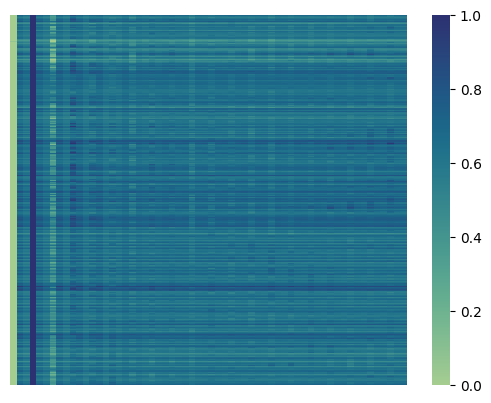

In [12]:
sns.heatmap(Data[3],cmap='crest', xticklabels=False, yticklabels=False)

In [13]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(Class_Label)

In [14]:
Feature_extractor = Model(inputs=model.input,outputs=model.get_layer('dense').output)

In [15]:
x = layers.Dropout(0.2)(Feature_extractor.output)
x = layers.Dense(6, activation='softmax')(x)
fine_tuned_model = Model(inputs=Feature_extractor.input, outputs=x)
for layer in fine_tuned_model.get_layer('vgg19').layers:
    layer.trainable = False
fine_tuned_model.get_layer('vgg19').trainable = False
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,052,745 (91.75 MB)

 Trainable params: 4,028,361 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
Data = np.array(Data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, random_state=42)

In [17]:
fine_tuned_model.fit(X_train,y_train,epochs = 10,batch_size = 32,validation_split = 0.3)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 556ms/step - accuracy: 0.3003 - loss: 29.0004 - val_accuracy: 0.6143 - val_loss: 2.2681
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.5740 - loss: 2.8170 - val_accuracy: 0.7376 - val_loss: 0.9311
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.7165 - loss: 1.0394 - val_accuracy: 0.6999 - val_loss: 1.0573
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.7626 - loss: 0.7654 - val_accuracy: 0.7156 - val_loss: 1.0458
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.7617 - loss: 0.8223 - val_accuracy: 0.7628 - val_loss: 0.7448
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.8167 - loss: 0.5441 - val_accuracy: 0.8366 - val_loss: 0.5347
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.8594 - loss: 0.3721 - val_accuracy: 0.8154 - val_loss: 0.5865
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.8826 - loss: 0.3657 - val_acc

In [18]:
loss , accuracy = fine_tuned_model.evaluate(X_test,y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8255 - loss: 0.5648


## Predicting for the given data

In [19]:
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-v2-dataset/MFCC-files-v2-20241024'
file_names = os.listdir(folder_path)
Data = []
meta_data = []
L = 2584  # Target number of frames

for file in file_names:
    file_path = os.path.join(folder_path, file)
    meta_data.append(file)
    df = pd.read_csv(file_path, header=None)
    mfcc_data = df.T
    delta_mfcc = librosa.feature.delta(mfcc_data)
    delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
    interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
    for i in range(mfcc_data.shape[1]):
        interleaved_mfcc[i * 3] = mfcc_data[i]
        interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
        interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
    mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
    Data.append(mfcc_data_scaled)

In [20]:
meta_data = np.array(meta_data.extend(y_train))

In [21]:
Feature_extractor = Model(inputs=fine_tuned_model.input,outputs=fine_tuned_model.get_layer('dense').output)

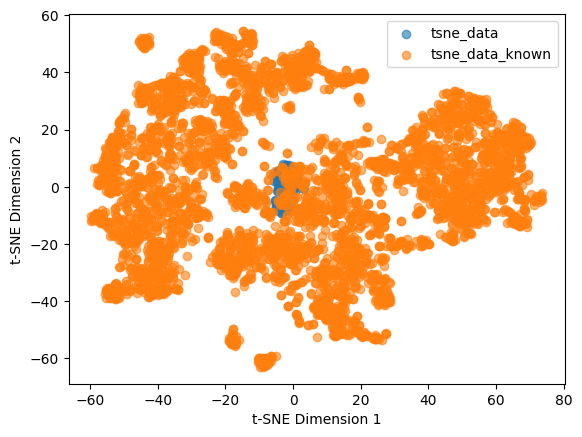

In [22]:
Features = []
stride = 500
for i in range(len(Data)):
    Features_ = sliding_window(Data[i],L,stride)
    window_feature = []
    for j in range(len(Features_)):
        window_feature.append(Feature_extractor(Features_[j].reshape(1,2584,60,1))[0])
    window_feature = np.array(window_feature)
    Features.append(np.mean(window_feature, axis=0))
Features_known = []
for i in range(len(X_train)):
    Features_ = sliding_window(X_train[i],L,stride)
    window_feature = []
    for j in range(len(Features_)):
        window_feature.append(Feature_extractor(Features_[j].reshape(1,2584,60,1))[0])
    Features_known.append(np.mean(window_feature, axis=0))
Features = np.array(Features)
Features_known = np.array(Features_known)
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(Features)
tsne_data_known = model.fit_transform(Features_known)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label="tsne_data", alpha=0.6)
plt.scatter(tsne_data_known[:, 0], tsne_data_known[:, 1], label="tsne_data_known", alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

### Clustering the Given Data

In [23]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(Features)
Cluster_label = kmeans.labels_
kmeans_known = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(Features_known)
Cluster_label_known = kmeans_known.labels_
pca = PCA(n_components=2)
features_pca = pca.fit_transform(Features)
silhouette = silhouette_score(Features, kmeans.labels_)
db_index = davies_bouldin_score(Features, kmeans.labels_)
ch_index = calinski_harabasz_score(Features,kmeans.labels_)
print(f'silhoutte_score: {silhouette} , Davies-Bouldin Index: {db_index} , Calinski-Harabasz Index: {ch_index}')
pca = PCA(n_components=2)
features_pca_known = pca.fit_transform(Features_known)
silhouette_known = silhouette_score(Features_known, kmeans.labels_)
db_index_known = davies_bouldin_score(Features_known, kmeans.labels_)
ch_index_known = calinski_harabasz_score(Features_known,kmeans.labels_)
print(f'silhoutte_score: {silhouette_known} , Davies-Bouldin Index: {db_index_known} , Calinski-Harabasz Index: {ch_index_known}')
# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_pca_known[:, 0], features_pca_known[:, 1], c=Cluster_label_known, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")  
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Clustered known Data")
plt.show()
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=Cluster_label, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")  
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Clustered Data")
plt.show()

silhoutte_score: 0.20511986315250397 , Davies-Bouldin Index: 1.564542345488765 , Calinski-Harabasz Index: 30.612341069593114


ValueError: Found input variables with inconsistent numbers of samples: [4242, 116]

In [24]:
###### print(meta_data)
result_df = pd.DataFrame({'CLuster_Label': Cluster_label, 'MetaData': meta_data})
result_df.to_csv('Cluster.csv', index=False)
result_df.head()

,CLuster_Label,MetaData
0,2,None
1,1,None
2,0,None
3,2,None
4,0,None


### Identifying k closest vectors

In [25]:
Asha_Bhosale_path = '/kaggle/input/ds203-songs/Asha_Bhosale-20241030T093033Z-001/Asha_Bhosale/Aaj_Tere_Piya_Ki_Talash_Ho_Rahi_Hai_-_Mahasati_Savitri_128_Kbps.mp3'
Michael_Jackson_path = '/kaggle/input/ds203-songs/Michael Jackson-20241030T093047Z-001/Michael Jackson/bad.mp3'
kishor_kumar_path = '/kaggle/input/ds203-songs/KISHORE_KUMAR-20241030T093039Z-001/KISHORE_KUMAR/oldKalakaar-Neele Neele Ambar.mp3'
jan_gan_man_path = '/kaggle/input/ds203-songs/Jan Gan Man-20241030T093036Z-001/Jan Gan Man/jan-gan-man-adhinayak-jai-hai-full-song--by-priyanka-chopra.mp3'
marth_lavan_path = '/kaggle/input/ds203-songs/MARATHI_LAVNI/MARATHI_LAVNI/Aase Wajwa Ki  Dholki  Siddharth Jadhav, Manasi Naik andLavani Mandali.mp3'
marth_bhav_path = '/kaggle/input/ds203-songs/Marathi Bhav Geet Songs/Marathi Bhav Geet Songs/Aali Kuthun Shi Kani Taal Mrudungachi Dhun- Vasant Azgaonkar, Bhaktigeet.mp3'
def read(file_path):
    mfcc_data = create_MFCC_coefficients(file_path) 
    if mfcc_data is not None:
        delta_mfcc = librosa.feature.delta(mfcc_data)
        delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
        interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
        for i in range(mfcc_data.shape[1]):
            interleaved_mfcc[i * 3] = mfcc_data[i]
            interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
            interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
        mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
        Features_ = sliding_window(mfcc_data_scaled,L,stride)
        window_feature = []
        for j in range(len(Features_)):
            window_feature.append(Feature_extractor(Features_[j].reshape(1,2584,60,1))[0])
        window_feature = np.array(window_feature)
        return np.mean(window_feature, axis=0)
Asha_Bhosale = read(Asha_Bhosale_path)
Michael_Jackson = read(Michael_Jackson_path)
kishor_kumar = read(kishor_kumar_path)
jan_gan_man = read(jan_gan_man_path)
marth_lavan = read(marth_lavan_path)
marth_bhav = read(marth_bhav_path)
vectors = {
    "Asha_Bhosale": Asha_Bhosale,
    "Michael_Jackson": Michael_Jackson,
    "kishor_kumar": kishor_kumar,
    "jan_gan_man": jan_gan_man,
    "marth_lavan": marth_lavan,
    "marth_bhav": marth_bhav
}

In [26]:
def top_k_closest_cosine(vectors, target_vector, k=10):
    similarities = [1 - distance.cosine(target_vector, vec) for vec in vectors]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return top_k_indices
A = top_k_closest_cosine(Features,Asha_Bhosale)
M = top_k_closest_cosine(Features,Michael_Jackson)
K = top_k_closest_cosine(Features,kishor_kumar)
J = top_k_closest_cosine(Features,jan_gan_man)

In [27]:
print(A)

[64 59 18 77 46 57 72  5 22 81]


In [28]:
A = meta_data[A]
M = meta_data[M]
K = meta_data[K]
J = meta_data[J]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
print(A,M,K,J)

### Labelling Clusters

In [ ]:
Centroid = kmeans.cluster_centers_
print(Centroid.shape)
cluster_labels = {}
for i in range(len(Centroid)):
    target_vector = Centroid[i]
    closest_name = None
    closest_similarity = -1  
    for name, vector in vectors.items():
        similarity = 1 - cosine(target_vector, vector) 
        if similarity > closest_similarity:
            closest_similarity = similarity
            closest_name = name
    cluster_labels[i] = closest_name

In [ ]:
print(cluster_labels)

In [ ]:
Feature_extractor.save('Feature_Extractor.keras')